Approach 1 of 3 for hierarchical supervised classification: use finetuned legalSmall_case_classifier as the case classification model, and then use off-the-shelf DistilBERT for prompt and case quote embeddings.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install datasets
from datasets import Dataset, load_dataset
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# load the top 10,000 training data example
df = pd.read_csv('/content/drive/MyDrive/6.8610/NLP Final Project/top_10000_training_data.csv.gz', compression='gzip')
print(df.head())

    dest_id  source_id   dest_date  \
0  11582807   11781059  1999-08-16   
1  11582807   11781059  1999-08-16   
2  11582807   11781059  1999-08-16   
3  11665092   11781059  1999-07-13   
4  11123976   11781059  2001-03-16   

                                          dest_court  \
0  United States Court of Appeals for the Sixth C...   
1  United States Court of Appeals for the Sixth C...   
2  United States Court of Appeals for the Sixth C...   
3  United States Court of Appeals for the Fifth C...   
4  United States Court of Appeals for the Eighth ...   

                  dest_name                                      dest_cite  \
0  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
1  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
2  United States v. Houston  United States v. Houston, 187 F.3d 593 (1999)   
3     United States v. Ruiz     United States v. Ruiz, 180 F.3d 675 (1999)   
4   United States v. Nation   United States 

In [ ]:
df.shape #currently this is the full 2 million rows; should cut to 10,000 since that's what case classifier was trained on

(2076241, 13)

In [ ]:
baseline_df = df[['destination_context', 'quote', 'passage_id', 'source_name']]
baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])

<ipython-input-6-ca2fcde1146e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["label"], _ = pd.factorize(baseline_df["passage_id"])


In [ ]:
baseline_df = baseline_df[:10000]
baseline_df.shape
baseline_df

,destination_context,quote,passage_id,source_name,label
0,If Houston’s escape is to be deemed a violent...,otherwise involve! ] conduct that presents a s...,11781059_7,United States v. Harris,0
1,If Houston’s escape is to be deemed a violent...,otherwise involves conduct that presents a ser...,11781059_7,United States v. Harris,0
2,Id. at 323 (finding that although the Ohio ki...,otherwise involves conduct that presents a ser...,11781059_7,United States v. Harris,0
3,” We rejected an identical argument in United ...,presenting] a serious potential risk of physic...,11781059_7,United States v. Harris,0
4,The court sentenced Nation pursuant to U.S.S....,involves conduct that presents a serious poten...,11781059_7,United States v. Harris,0
...,...,...,...,...,...
9995,"Lee, 236 F.R.D. at 204; see also Robidoux, 98...",the representative parties will fairly and ade...,11239507_17,"Baffa v. Donaldson, Lufkin & Jenrette Securiti...",77
9996,"To establish adequacy, plaintiffs must show t...",antagonistic to the interest of other members ...,11239507_3,"Baffa v. Donaldson, Lufkin & Jenrette Securiti...",76
9997,"To establish adequacy, plaintiffs must show t...","qualified, experienced and able to conduct the...",11239507_3,"Baffa v. Donaldson, Lufkin & Jenrette Securiti...",76
9998,"\nIn support of commonality, Maziarz asserts t...","qualified, experienced and able to conduct the...",11239507_3,"Baffa v. Donaldson, Lufkin & Jenrette Securiti...",76


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from torch.nn import functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
#need to instantiate a copy of the model for case classification to substitute finetuned parameters

class LegalBERTSmallClassifier(torch.nn.Module):
    def __init__(self, n_classes):
        super(LegalBERTSmallClassifier, self).__init__()
        self.legalbertSmall = AutoModelForSequenceClassification.from_pretrained(
            "nlpaueb/legal-bert-small-uncased",
            num_labels=n_classes
        )

        # Freeze all parameters except classifier
        for param in self.legalbertSmall.parameters():
            param.requires_grad = False
        for param in self.legalbertSmall.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        output = self.legalbertSmall(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return output.logits  # Note: need to return logits for classification

In [ ]:
class LegalPrecedentMatcher:
    def __init__(self, case_classifier_path, num_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device

        # Initialize with exact same architecture as training
        self.case_classifier = LegalBERTSmallClassifier(n_classes=num_labels)

        # Load the state dict
        state_dict = torch.load(case_classifier_path, map_location=device)
        self.case_classifier.load_state_dict(state_dict)
        self.case_classifier.to(device)
        self.case_classifier.eval()

        # Initialize models for embeddings
        self.tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-small-uncased')
        self.bert_model = AutoModel.from_pretrained('nlpaueb/legal-bert-small-uncased')
        self.bert_model.to(device)
        self.bert_model.eval()

    def classify_case(self, quote):
        with torch.no_grad():
            # Get tokenizer outputs
            tokenizer_output = self.tokenizer(quote,
                                            return_tensors='pt',
                                            padding=True,
                                            truncation=True,
                                            max_length=512)

            # Only pass the expected arguments
            inputs = {
                'input_ids': tokenizer_output['input_ids'].to(self.device),
                'attention_mask': tokenizer_output['attention_mask'].to(self.device)
            }

            outputs = self.case_classifier(**inputs)
            predicted_label = torch.argmax(outputs, dim=1)

        return predicted_label.item()

    def get_embedding(self, text):
        with torch.no_grad():
            # Get tokenizer outputs
            tokenizer_output = self.tokenizer(text,
                                            return_tensors='pt',
                                            padding=True,
                                            truncation=True,
                                            max_length=512)

            # Only pass the expected arguments
            inputs = {
                'input_ids': tokenizer_output['input_ids'].to(self.device),
                'attention_mask': tokenizer_output['attention_mask'].to(self.device)
            }

            outputs = self.bert_model(**inputs)
            embedding = torch.mean(outputs.last_hidden_state, dim=1)

        return embedding.cpu().numpy()

    def find_most_similar_quote(self, query_quote, candidate_quotes):
        query_embedding = self.get_embedding(query_quote)

        candidate_embeddings = []
        for quote in candidate_quotes:
            embedding = self.get_embedding(quote)
            candidate_embeddings.append(embedding)

        candidate_embeddings = np.vstack(candidate_embeddings)
        similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]
        most_similar_idx = np.argmax(similarities)

        return {
            'most_similar_quote': candidate_quotes[most_similar_idx],
            'similarity_score': similarities[most_similar_idx],
            'all_similarities': similarities
        }

In [ ]:
baseline_df_labels = baseline_df["label"].to_list()[:10000]
num_labels_baseline = len(baseline_df["label"].unique())
num_labels_baseline

78

In [ ]:
#inference (single example) pipeline
#using case_classifier_df (the top-10k rows version of baseline_df)

case_classifier_df = df[['destination_context', 'quote', 'passage_id', 'source_name', 'source_id']]
case_classifier_df["label"], _ = pd.factorize(case_classifier_df["source_id"])
training_labels = case_classifier_df["label"].to_list()[:10000]
num_labels = len(set(training_labels))

<ipython-input-19-0d53235b9d6f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_classifier_df["label"], _ = pd.factorize(case_classifier_df["source_id"])


In [ ]:
num_labels

55

In [ ]:

def main(df, query_quote, case_classifier_path):
    # Get number of unique labels from the DataFrame
    #num_labels = len(df['label'].unique())

    # Initialize the matcher
    matcher = LegalPrecedentMatcher(case_classifier_path, num_labels)
    valid_labels = set(training_labels)

    # Step 1: Classify the case
    predicted_label = matcher.classify_case(query_quote)

    # Step 2: Get all quotes from the predicted case
    case_quotes = df[df['label'].isin(valid_labels) & (df['label'] == predicted_label)]['destination_context'].tolist()

    if not case_quotes:
        return {
            'predicted_case_label': predicted_label,
            'predicted_case_name': 'No matching case found',
            'most_similar_quote': None,
            'similarity_score': None
        }

    # Step 3: Find the most similar quote
    result = matcher.find_most_similar_quote(query_quote, case_quotes)

    return {
        'predicted_case_label': predicted_label,
        'predicted_case_name': df[df['label'] == predicted_label]['source_name'].iloc[0],
        'most_similar_quote': result['most_similar_quote'],
        'similarity_score': result['similarity_score']
    }

In [ ]:
# Test with exact same file path as in training
baseline_df = baseline_df[:10000]
test_quote = baseline_df['quote'].iloc[2459]
results = main(baseline_df, test_quote, '/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_Case_Classifier_top10k.pth')
print(f"Predicted Case: {results['predicted_case_name']}")
print(f"Most Similar Quote (Similarity: {results['similarity_score']:.3f}):")
print(results['most_similar_quote'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-b71f38eb5d65>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

Predicted Case: Walczak v. Florida Union Free School District
Most Similar Quote (Similarity: 0.830):
 SRO Appeal No. 90-17. The officer’s decision is binding upon both the school district and the parents unless it is appealed to a State Review Officer. 8 N.Y.C.R.R. § 200.5(i)(4)(v). The Review Officer’s decision, if any, is final unless either party seeks judicial review. 8 N.Y.C.R.R. § 200.5(j)(3). These are “


In [ ]:
baseline_df.iloc[2459]

,2459
destination_context,"Additionally, they argue that: (1) they lacke..."
quote,"final judgments, orders, and decrees [pursuant..."
passage_id,11852631_30
source_name,Fleet Data Processing Corp. v. Branch (In re B...
label,19


Evaluations

In [ ]:
import numpy as np
import random
from tqdm import tqdm

In [ ]:
def evaluate_full_system(df, matcher, n_samples=100, n_distractors=9):
    """
    Evaluates both case classification and passage matching

    Args:
        df: DataFrame with columns 'quote', 'destination_context', 'source_name', 'label'
        matcher: Initialized LegalPrecedentMatcher instance
        n_samples: Number of test cases to evaluate
        n_distractors: Number of incorrect passages to include

    Returns:
        Dictionary with evaluation metrics
    """
    correct_case = 0
    correct_passage = 0
    correct_both = 0
    mrr = 0  # Mean Reciprocal Rank

    # Sample test cases
    all_indices = list(range(len(df)))
    test_indices = np.random.choice(all_indices, n_samples, replace=False)

    # For storing detailed results
    detailed_results = []

    # Progress bar
    for idx in tqdm(test_indices, desc="Evaluating"):
        # Get query quote and true information
        query = df.iloc[idx]['quote']
        true_case = df.iloc[idx]['source_name']
        true_passage = df.iloc[idx]['destination_context']

        # Get distractor passages (randomly sampled)
        # Exclude the current index from potential distractors
        possible_distractors = [i for i in all_indices if i != idx]
        distractor_indices = np.random.choice(
            possible_distractors,
            n_distractors,
            replace=False
        )

        # Create list of candidate passages (true passage + distractors)
        candidate_passages = [true_passage] + [
            df.iloc[i]['destination_context'] for i in distractor_indices
        ]

        # Shuffle candidates and keep track of true passage position
        random.shuffle(candidate_passages)
        true_passage_idx = candidate_passages.index(true_passage)

        # Get model predictions
        # First, classify the case
        predicted_label = matcher.classify_case(query)
        predicted_case = df[df['label'] == predicted_label]['source_name'].iloc[0]

        # Then, find most similar passage
        result = matcher.find_most_similar_quote(query, candidate_passages)
        similarities = result['all_similarities']

        # Find rank of true passage in similarity scores
        ranked_indices = np.argsort(-similarities)  # Sort in descending order
        passage_rank = np.where(ranked_indices == true_passage_idx)[0][0] + 1

        # Update metrics
        case_correct = (predicted_case == true_case)
        passage_correct = (passage_rank == 1)

        if case_correct:
            correct_case += 1
        if passage_correct:
            correct_passage += 1
        if case_correct and passage_correct:
            correct_both += 1
        mrr += 1.0 / passage_rank

        # Store detailed results for this sample
        detailed_results.append({
            'query': query,
            'true_case': true_case,
            'predicted_case': predicted_case,
            'case_correct': case_correct,
            'passage_rank': passage_rank,
            'true_passage': true_passage,
            'predicted_passage': candidate_passages[ranked_indices[0]],
            'similarity_score': similarities[ranked_indices[0]]
        })

    # Calculate final metrics
    results = {
        'case_accuracy': correct_case / n_samples,
        'passage_accuracy': correct_passage / n_samples,
        'full_system_accuracy': correct_both / n_samples,
        'mrr': mrr / n_samples,
        'detailed_results': detailed_results  # Store all individual results
    }

    return results

In [ ]:
def print_evaluation_results(results):
    """Pretty prints the evaluation results"""
    print("\nEvaluation Results:")
    print("-" * 50)
    print(f"Case Classification Accuracy: {results['case_accuracy']:.3f}")
    print(f"Passage Matching Accuracy: {results['passage_accuracy']:.3f}")
    print(f"Full System Accuracy: {results['correct_both']:.3f}")
    print(f"Mean Reciprocal Rank: {results['mrr']:.3f}")

    print("\nDetailed Error Analysis:")
    print("-" * 50)
    # Print a few examples where the system failed
    print("Examples of errors:")
    errors = [r for r in results['detailed_results']
             if not (r['case_correct'] and r['passage_rank'] == 1)]

    for i, error in enumerate(errors[:3]):  # Show first 3 errors
        print(f"\nError Example {i+1}:")
        print(f"Query: {error['query'][:200]}...")
        print(f"True Case: {error['true_case']}")
        print(f"Predicted Case: {error['predicted_case']}")
        print(f"Passage Rank: {error['passage_rank']}")
        print(f"Similarity Score: {error['similarity_score']:.3f}")

In [ ]:
matcher = LegalPrecedentMatcher('/content/drive/MyDrive/6.8610/NLP Final Project/LegalSmall_Case_Classifier_top10k.pth', num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-b71f38eb5d65>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

In [ ]:
results = evaluate_full_system(baseline_df, matcher, n_samples=100, n_distractors=1)
print_evaluation_results(results)

Evaluating: 100%|██████████| 100/100 [00:07<00:00, 14.17it/s]


Evaluation Results:
--------------------------------------------------
Case Classification Accuracy: 0.000
Passage Matching Accuracy: 0.780


KeyError: 'correct_both'

In [ ]:
#accuracies for plotting
case_classification_accuracies = [.140, .110, .06, .050, .040, .060, .040, .070, .060, .040, .050, .040, .060, .080, .060, .070, .050, .040, .040]
passage_matching_accuracy = [0.780, 0.740, 0.670, 0.540, 0.520, 0.600, 0.530, 0.540, 0.430, 0.400, .440, 0.450, 0.480, 0.390, .390, .330, .430, .470, .310]
passage_matching_accuracy_type2 = [0.550, 0.280, 0.150, 0.100, 0.200, 0.100, 0.200, 0.100, 0.200]
passage_matching_accuracy_type3 = [0.75, 0.75, 0.45, 0.65, .300, .500, .300, .450, .200]
num_options = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

len(num_options) == len(passage_matching_accuracy)

True

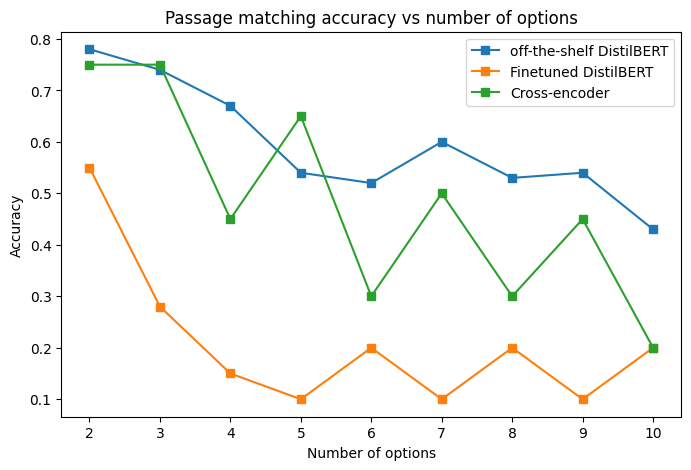

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(num_options[:9], passage_matching_accuracy[:9], marker='s', label="off-the-shelf DistilBERT")
plt.plot(num_options[:9], passage_matching_accuracy_type2, marker='s', linestyle='-', label="Finetuned DistilBERT")
plt.plot(num_options[:9], passage_matching_accuracy_type3, marker='s', linestyle='-', label='Cross-encoder')

# Customizing the plot
plt.title("Passage matching accuracy vs number of options")
plt.xlabel("Number of options")
plt.ylabel("Accuracy")
plt.xticks(range(2, 11))  # Ensures all x values are shown
plt.legend()

# Show plot
plt.show()

In [ ]:
num_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(num_options, passage_matching_accuracy_type2, label='samples chosen randomly', color="red")
plt.plot(num_options, passage_matching_accuracy_type3, label='samples chosen deliberately', color="blue")
plt.xticks(range(2,11))
plt.legend()
plt.xlabel('Number of Options')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Options')
plt.show()